In [2]:
!unrar x /content/drive/MyDrive/CoNSeP.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/CoNSeP.rar

Creating    Test                                                      OK
Extracting  Test/.DS_Store                                                 0%  OK 
Creating    Test/Images                                               OK
Extracting  Test/Images/test_1.png                                         0%  1%  OK 
Extracting  Test/Images/test_10.png                                        1%  2%  OK 
Extracting  Test/Images/test_11.png                                        2%  3%  OK 
Extracting  Test/Images/test_12.png                                        4%  5%  OK 
Extracting  Test/Images/test_13.png                                        5%  6%  OK 
Extracting  Test/Images/test_14.png                                        6%  7%  OK 
Extracting  Test/Images/test_2.png        

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob
from skimage import io
import scipy.io as sio
from skimage import data, io, util
from matplotlib import pyplot as plt
import numpy as np

import cv2
import os
import shutil

In [4]:
test_folder = glob.glob("/content/Test/Images")[0]
train_folder = glob.glob("/content/Train/Images")[0]



train_dir = "/content/ContrainSepdata"
test_dir = "/content/ContestSepdata"

try:
    shutil.rmtree(train_dir)
except:
    pass

try:
    shutil.rmtree(test_dir)
except:
    pass
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [5]:
def show(img):
  io.imshow(img)
  plt.show()

In [6]:
def create_centroid_mask(centroids, height, width):
    cent_img = np.zeros((height,width))
    cent_img[tuple(centroids.T)] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    centroids_mask = cv2.dilate(cent_img, kernel, iterations=2)
    
    return centroids_mask

def read_image(imagePath):
    image = io.imread(imagePath)[:,:,:3]
    
    return image

def fix_type(type_map):
    type_map[(type_map == 3) | (type_map == 4)] = 3
    type_map[(type_map == 5) | (type_map == 6) | (type_map == 7)] = 4
    return type_map

def read_annotation(annotPath):
    mask = sio.loadmat(annotPath)
    
    type_map = fix_type(mask['type_map'])
    centroid_map = create_centroid_mask(mask['inst_centroid'].astype(int)[:,::-1], mask['inst_map'].shape[0], mask['inst_map'].shape[1])
    inst_map = mask['inst_map']
    nuclear_map = inst_map+0
    nuclear_map[nuclear_map!=0] = 1
    
    return centroid_map, inst_map, nuclear_map, type_map

for img_path in glob.glob("{}/*".format(test_folder)):
    print(img_path)
    
    image = read_image(img_path)
    centroid_map, inst_map, nuclear_map, type_map = read_annotation(img_path.replace("Images","Labels").replace(".png",".mat"))

    output_mask = np.zeros((image.shape[0],image.shape[1],7))
    output_mask[:,:,:3] = image/255.0
    output_mask[:,:,3] = inst_map # inst_mask
    output_mask[:,:,4] = nuclear_map # binary mask
    output_mask[:,:,5] = centroid_map # centroids_mask
    output_mask[:,:,6] = type_map # type mask

    output = util.view_as_windows(output_mask, (256,256,7), step=(245,245,7)).reshape(-1,256,256,7)#step=(245,245,7)
    
    for idx in range(output.shape[0]):
#         if 1 not in output[:,:,6] and 2 not in output[:,:,6]:
#             continue
        np.save("{}/{}_{}.npy".format(test_dir,os.path.basename(img_path).replace(".png",""),idx), output[idx])
        
for img_path in glob.glob("{}/*".format(train_folder)):
    print(img_path)
    
    image = read_image(img_path)
    centroid_map, inst_map, nuclear_map, type_map = read_annotation(img_path.replace("Images","Labels").replace(".png",".mat"))

    output_mask = np.zeros((image.shape[0],image.shape[1],7))
    output_mask[:,:,:3] = image/255.0
    output_mask[:,:,3] = inst_map # inst_mask
    output_mask[:,:,4] = nuclear_map # binary mask
    output_mask[:,:,5] = centroid_map # centroids_mask
    output_mask[:,:,6] = type_map # type mask

    output = util.view_as_windows(output_mask, (256,256,7), step=(128,128,7)).reshape(-1,256,256,7)#step=(245,245,7)
    
    for idx in range(output.shape[0]):
#         if 1 not in output[:,:,6] and 2 not in output[:,:,6]:
#             continue
        np.save("{}/{}_{}.npy".format(train_dir,os.path.basename(img_path).replace(".png",""),idx), output[idx])

/content/Test/Images/test_3.png
/content/Test/Images/test_11.png
/content/Test/Images/test_14.png
/content/Test/Images/test_12.png
/content/Test/Images/test_13.png
/content/Test/Images/test_4.png
/content/Test/Images/test_6.png
/content/Test/Images/test_8.png
/content/Test/Images/test_5.png
/content/Test/Images/test_1.png
/content/Test/Images/test_10.png
/content/Test/Images/test_7.png
/content/Test/Images/test_2.png
/content/Test/Images/test_9.png
/content/Train/Images/train_13.png
/content/Train/Images/train_25.png
/content/Train/Images/train_14.png
/content/Train/Images/train_10.png
/content/Train/Images/train_2.png
/content/Train/Images/train_6.png
/content/Train/Images/train_20.png
/content/Train/Images/train_24.png
/content/Train/Images/train_27.png
/content/Train/Images/train_17.png
/content/Train/Images/train_8.png
/content/Train/Images/train_7.png
/content/Train/Images/train_12.png
/content/Train/Images/train_4.png
/content/Train/Images/train_21.png
/content/Train/Images/train

In [7]:
traindata=[]
for img_path in glob.glob("{}/*".format(train_dir)):
  inst = np.load(img_path)
  label=inst[:,:,3]
  mask = np.array(label)
  obj_ids = np.unique(mask)[1:] # first id is the background, so remove it
  num_objs = len(obj_ids)                       
     
  if(num_objs!=0):
        traindata.append(inst)
testdata=[]
for img_path in glob.glob("{}/*".format(test_dir)):
  inst = np.load(img_path)
  label=inst[:,:,3]
  mask = np.array(label)
  obj_ids = np.unique(mask)[1:] # first id is the background, so remove it
  num_objs = len(obj_ids)                       
     
  if(num_objs!=0):
        testdata.append(inst)
print(len(testdata))
print(len(traindata))

222
938


In [8]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 155343, done.
remote: Counting objects: 100% (7716/7716), done.
remote: Compressing objects: 100% (663/663), done.
remote: Total 155343 (delta 7100), reused 7571 (delta 7021), pack-reused 147627
Receiving objects: 100% (155343/155343), 304.94 MiB | 35.70 MiB/s, done.
Resolving deltas: 100% (137674/137674), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d version check against PyTorch's CUDA version


In [9]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import RPNHead
from torchvision.models.detection import MaskRCNN

import math
from tqdm import tqdm

import cv2


from engine import train_one_epoch, evaluate
import utils
import torchvision.transforms as T
#import transforms as T

In [10]:
class cmp17Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
    def __getitem__(self, idx):
        inst = self.root[idx]
        img = inst[:,:,:3]
        label=inst[:,:,3]
        id=inst[:,:,6]
        
        img = np.array(img)
        mask = np.array(label)

        obj_ids = np.unique(mask)[1:] # first id is the background, so remove it     
        masks = mask == obj_ids[:, None, None]  # split the color-encoded mask into a set of binary masks
        num_objs = len(obj_ids)      
        boxes = []
        lab = []
        area=0
        
        # find the boxes
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            l = np.where(label==obj_ids[i]) 
            lab.append(np.unique(id[l]))
  
            if(((xmin==xmax)or (ymin==ymax))):
              if(xmin==0):
                  xmin = 1
                  xmax = 1
              if(ymin==0):
                  ymin = 1
                  ymax = 1

              boxes.append([0.5*xmin,0.5* ymin, xmax,ymax])
            else:
               boxes.append([xmin,ymin,xmax,ymax])

        # convert everything into torch.Tensor
        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target["boxes"] = boxes
        target["masks"] = torch.as_tensor(masks, dtype=torch.uint8) #uint8
        target["image_id"] = torch.tensor([idx]) 
        target["area"] = area
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64) # suppose all instances are not crowd
        target["labels"] = torch.as_tensor(lab, dtype=torch.int64).flatten()
        


        if self.transform is not None:
              img = self.transform(img)
        return img.float(), target

        
    def __len__(self):
        return len(self.root)

In [11]:
def get_transform(train):
    transform = []
    transform.append(T.ToTensor())
    if train:
        #transform.append(T.Resize((500,500)))
        transform.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transform)


In [12]:
dataset = cmp17Dataset(traindata, get_transform(train=True))
    
    # define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

images, targets=dataset[90]
print(targets["masks"].shape)
print(targets["labels"])
print(type(targets["boxes"]))
print(type(images))





torch.Size([14, 256, 256])
tensor([4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 4, 4, 4, 2])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [13]:

def get_model_instance_segmentation(num_classes):
     # load an instance segmentation model pre-trained pre-trained on COCO
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280

    #create an anchor_generator for the FPN which by default has 5 outputs
    anchor_generator = AnchorGenerator(
    sizes=((8,16,32,64,128),),
    aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)
    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)


    model = MaskRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
                   mask_roi_pool=mask_roi_pooler)
   
    return model


In [17]:
def train(model, optimizer, data_loader, device, n_epochs, print_freq):
    # Perform training loop for n epochs
  loss_list = []
  model.train()
  for epoch in tqdm(range(n_epochs)):
      loss_epoch = []
      iteration=1
      for images,targets in tqdm(data_loader):

          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          optimizer.zero_grad()
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())
          losses.backward()       
          optimizer.step()
          loss_epoch.append(losses.item())
          
          # Plot loss every 10th iteration
          iteration+=1
      loss_epoch_mean = np.mean(loss_epoch) 
      loss_list.append(loss_epoch_mean) 
      # loss_list.append(loss_epoch_mean)    
      print("Average loss for epoch = {:.4f} ".format(loss_epoch_mean))
  plt.plot(list(range(epoch+1)), loss_list)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

 
  # Save model
 # model_nr = latest_model() + 1 # keep track of which model nr was just trained. 
  #save_path = 'PUT YOUR SAVE PATH HERE'+str(model_nr)
  torch.save(model.state_dict(), '/content/drive/MyDrive/MobileNetCONSEP2.pt')
  return loss_list


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  5%|▌         | 1/20 [01:51<35:12, 111.18s/it]

Average loss for epoch = 2.0611 



 10%|█         | 2/20 [03:42<33:18, 111.03s/it]

Average loss for epoch = 1.8844 



 15%|█▌        | 3/20 [05:31<31:16, 110.41s/it]

Average loss for epoch = 1.8501 



 20%|██        | 4/20 [07:22<29:26, 110.39s/it]

Average loss for epoch = 1.8429 



 25%|██▌       | 5/20 [09:11<27:30, 110.02s/it]

Average loss for epoch = 1.8223 



 30%|███       | 6/20 [11:00<25:35, 109.71s/it]

Average loss for epoch = 1.7985 



 35%|███▌      | 7/20 [12:50<23:46, 109.76s/it]

Average loss for epoch = 1.7864 



 40%|████      | 8/20 [14:40<21:56, 109.69s/it]

Average loss for epoch = 1.7715 



 45%|████▌     | 9/20 [16:29<20:05, 109.63s/it]

Average loss for epoch = 1.7602 



 50%|█████     | 10/20 [18:18<18:15, 109.52s/it]

Average loss for epoch = 1.7456 



 55%|█████▌    | 11/20 [20:08<16:24, 109.43s/it]

Average loss for epoch = 1.7164 



 60%|██████    | 12/20 [21:56<14:34, 109.26s/it]

Average loss for epoch = 1.7157 



 65%|██████▌   | 13/20 [23:45<12:44, 109.15s/it]

Average loss for epoch = 1.7109 



 70%|███████   | 14/20 [25:34<10:54, 109.11s/it]

Average loss for epoch = 1.7052 



 75%|███████▌  | 15/20 [27:23<09:05, 109.09s/it]

Average loss for epoch = 1.6902 



 80%|████████  | 16/20 [29:12<07:15, 108.98s/it]

Average loss for epoch = 1.6660 



 85%|████████▌ | 17/20 [31:01<05:27, 109.10s/it]

Average loss for epoch = 1.6494 



 90%|█████████ | 18/20 [32:51<03:38, 109.12s/it]

Average loss for epoch = 1.6449 



 95%|█████████▌| 19/20 [34:40<01:49, 109.15s/it]

Average loss for epoch = 1.6241 



100%|██████████| 20/20 [36:29<00:00, 109.48s/it]


Average loss for epoch = 1.6178 


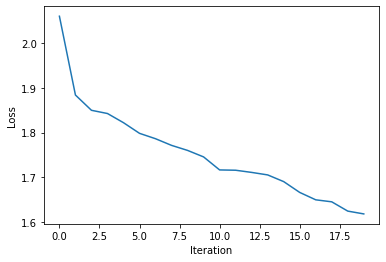

In [18]:
   # train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
num_classes = 5
    # use our dataset and defined transformations
dataset = cmp17Dataset(traindata, get_transform(train=True))
dataset_valid = cmp17Dataset(testdata[:3], get_transform(train=False))

    
    # define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

dataset_valid = torch.utils.data.DataLoader(
        testdata, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
model = get_model_instance_segmentation(num_classes)
    # move model to the right device
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
 
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
 # let's train it for 10 epochs
num_epochs = 20
loss_list=train(model, optimizer, data_loader, device, num_epochs, print_freq=15)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(5)

    # move model to the right device
model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/ResntetCONSEP.pt'))


In [19]:
dataset_test = cmp17Dataset(testdata, get_transform(train=False))

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)
output=[]
target=[]
for images, targets in tqdm(data_loader_test):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    target.append(targets[0])
    with torch.no_grad():
      model.eval()
      output.append( model(images)[0])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 222/222 [00:27<00:00,  8.03it/s]


In [20]:
def IoU(y_real, y_pred):
  # Intersection over Union loss function
  intersection = y_real*y_pred
  union = (y_real+y_pred)-(y_real*y_pred)
  return np.sum(intersection)/np.sum(union)

def dice_coef(y_real, y_pred, smooth=0):
      return 2. * (y_real*y_pred).sum() / (y_real+y_pred).sum()


In [21]:
IoU_scores_list=[]
dice_coef_scores_list=[]
for i in range(len(target)):
  target_im = target[i]['masks'][0].cpu().detach().numpy()
  for k in range(len(target[i]['masks'])):
        target_im2 = target[i]['masks'][k].cpu().detach().numpy()
        target_im2[target_im2>0.5] = 1
        target_im2[target_im2<0.5] = 0
        target_im = target_im+target_im2
  target_im[target_im>0.5] = 1
  target_im[target_im<0.5] = 0
  target_im = target_im.astype('int64')
  
  output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
  for k in range(len(output[i]['masks'])):
    output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
    output_im2[output_im2>0.5] = 1
    output_im2[output_im2<0.5] = 0
    output_im = output_im+output_im2

  output_im[output_im>0.5] = 1
  output_im[output_im<0.5] = 0
  output_im = output_im.astype('int64')
  IoU_score = IoU(y_real=target_im, y_pred=output_im) 
  IoU_scores_list.append(IoU_score)
  dice_coef_score = dice_coef(y_real=target_im, y_pred=output_im)
  dice_coef_scores_list.append(dice_coef_score)
print('mean IoU score for test set:', np.mean(IoU_scores_list))
print('mean Dice Coefficient score for test set:', np.mean(dice_coef_scores_list))


mean IoU score for test set: 0.49309408709198926
mean Dice Coefficient score for test set: 0.6470074654244967


In [22]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        
    plt.show()


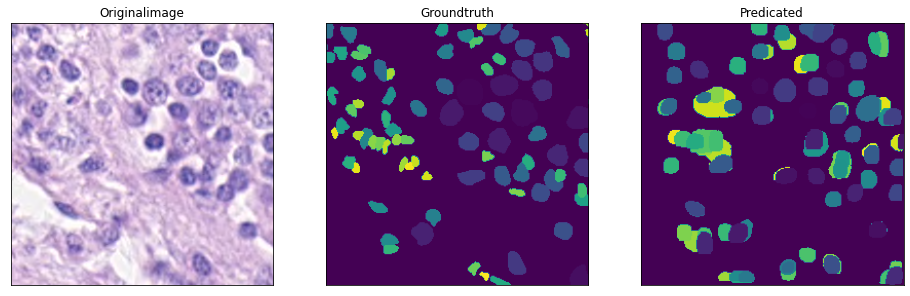

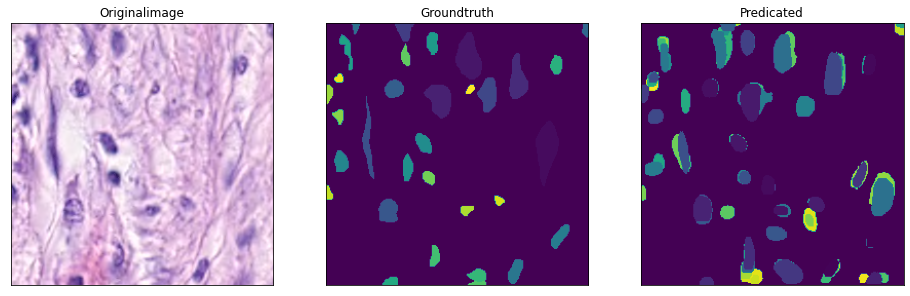

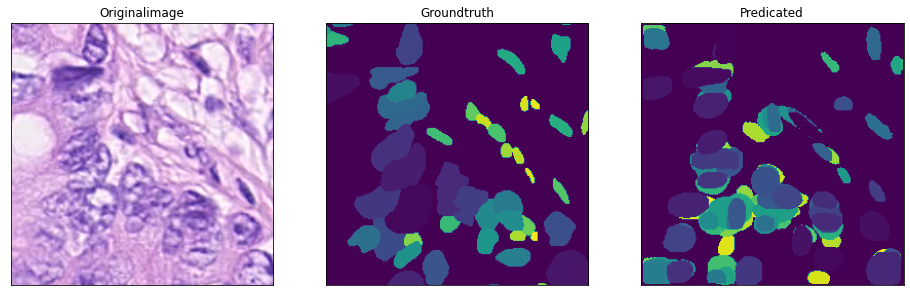

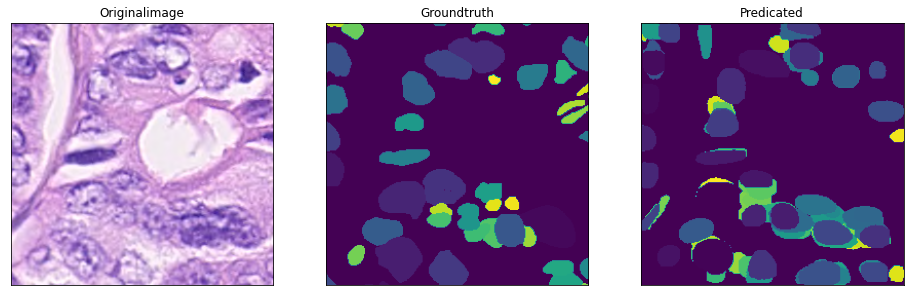

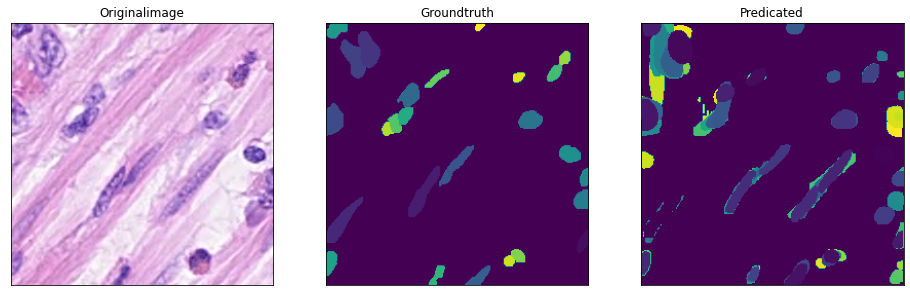

In [23]:
n = 5
ids=[0,10,15,30,26]
for i in ids:
  # pick one image from the test set
  img, apred = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  orig=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  t=apred['masks'].permute(1,2,0)
  g=np.argmax(t,axis=2) 
  k=(prediction[0]['masks']>0.5).mul(1).squeeze().detach().cpu().numpy()
  k=np.argmax(k,axis=0) 
  visualize(OriginalImage = orig, GroundTruth=g,Predicated=k)


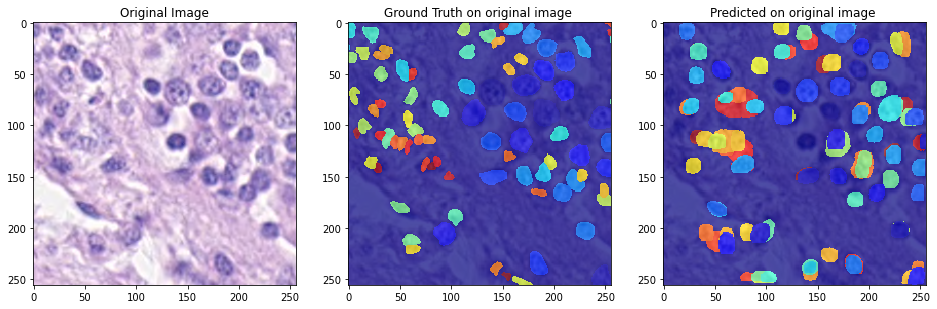

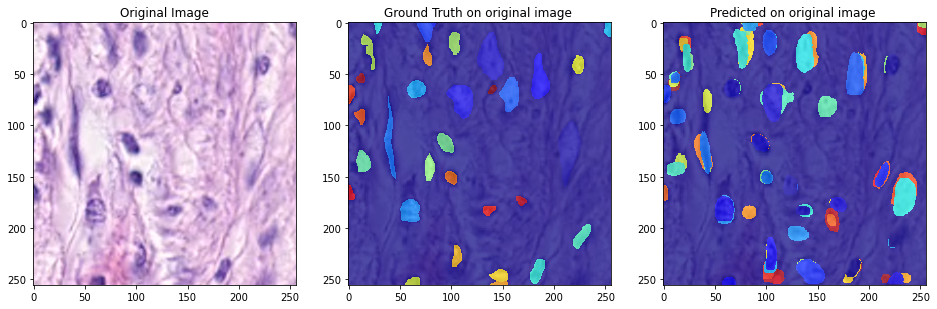

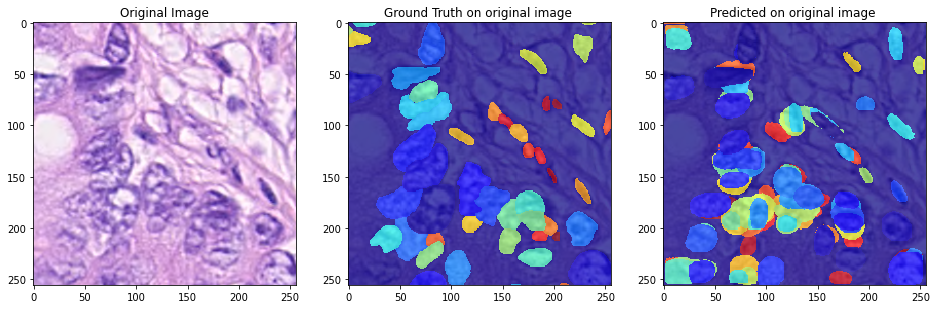

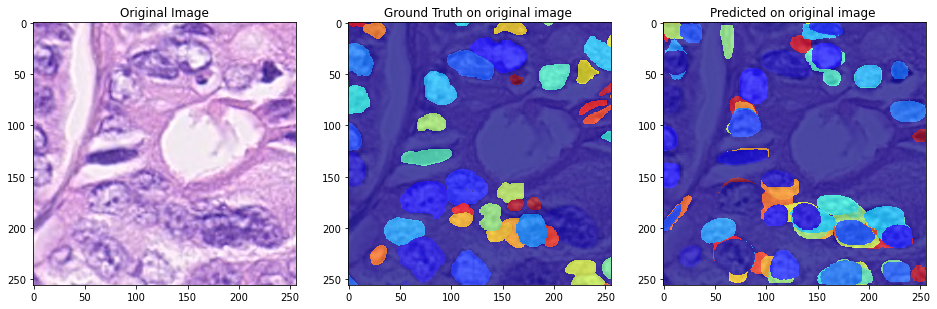

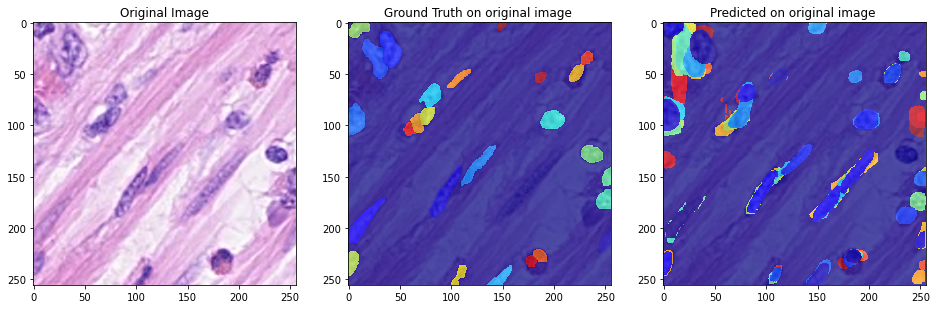

In [24]:
n = 5
ids=[0,10,15,30,26]
for i in ids:
  # pick one image from the test set
  img, apred = dataset_test[i]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  orig=Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  t=apred['masks'].permute(1,2,0)
  g=np.argmax(t,axis=2) 
  k=(prediction[0]['masks']>0.5).mul(1).squeeze().detach().cpu().numpy()
  k=np.argmax(k,axis=0) 
  plt.figure(figsize=(16, 5))
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(orig)
  plt.subplot(1, 3, 2)
  plt.imshow(orig, interpolation='none')
  plt.imshow(g, 'jet', interpolation='none', alpha=0.7)
  plt.title("Ground Truth on original image ")
  plt.subplot(1, 3, 3)
  plt.imshow(orig, interpolation='none')
  plt.imshow(k, 'jet', interpolation='none', alpha=0.7)
  plt.title("Predicted on original image ")
  
  plt.show()
